In [1]:
# importacao das bibliotecas utilizadas
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.exposure import rescale_intensity
from scipy.ndimage import gaussian_filter
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

In [177]:
# importacao das imagens
baboon = cv2.imread('imgs/baboon.png',cv2.IMREAD_GRAYSCALE)
butterfly = cv2.imread('imgs/butterfly.png',cv2.IMREAD_GRAYSCALE)

### Pré-processamento

In [183]:
def rescale(image,gmax,gmin,fmax,fmin):
    output = np.zeros(image.shape,dtype='uint8')
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            output[i][j] = (((gmax - gmin) / (fmax - fmin)) * (image[i][j] - fmin)) + gmin
    return output

### 1.1 Pontilhado Ordenado (Half-toning)

In [184]:
m33 = np.array([[6,8,4],[1,0,3],[5,2,7]])
m44 = np.array([[0,12,3,15],[8,4,11,7],[2,14,1,13],[10,6,9,5]])

In [185]:
def half_toning(img,mask):
    gmax = mask.shape[0]*mask.shape[1]
    gmin = 0
    fmax = 255
    fmin = 0
    
    img_norm = rescale(img,gmax,gmin,fmax,fmin)
    
    new_x = img_norm.shape[0] * mask.shape[0]
    new_y = img_norm.shape[1] * mask.shape[1]
    
    n = mask.shape[0]
    m = mask.shape[1]
    
    output = np.zeros((new_x,new_y),dtype='uint8')
    
    for i in range(img_norm.shape[0]):
        for j in range(img_norm.shape[1]):
            mask_res = np.ndarray(mask.shape)
            mask_res = mask < img_norm[i,j]
            
            for x in range(n):
                for y in range(m):
                    output[i*n+x,j*m+y] = mask_res[x,y]
    
    return output

In [186]:
baboon_m33 = half_toning(baboon,m33)
baboon_m44 = half_toning(baboon,m44)

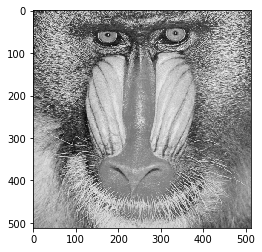

In [187]:
plt.imshow(baboon,'gray')

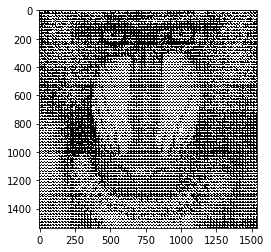

In [188]:
plt.imshow(baboon_m33,'gray')

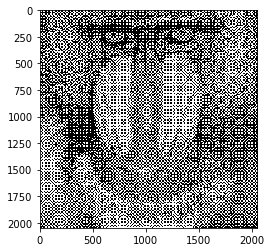

In [189]:
plt.imshow(baboon_m44,'gray')